In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat

In [11]:
int(np.round(4001/2))

2000

<Figure size 1000x800 with 0 Axes>

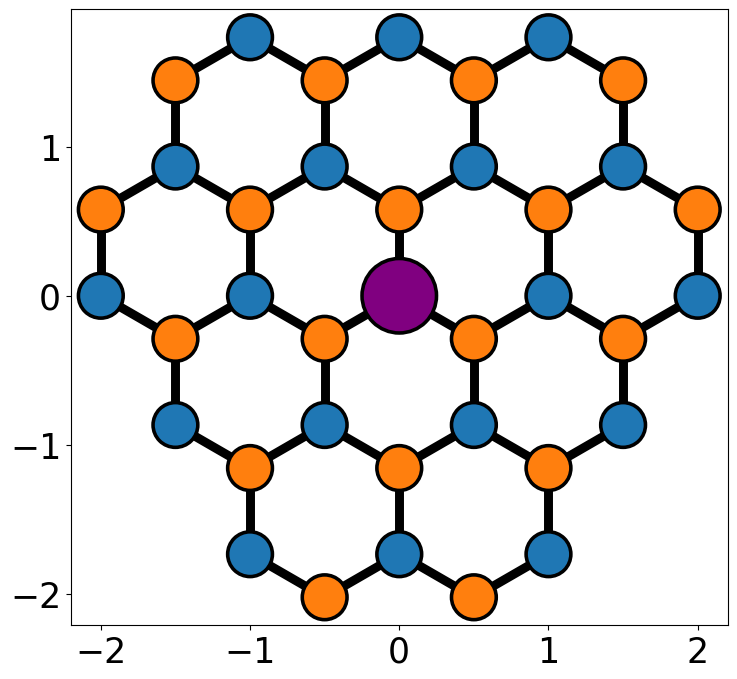

<Figure size 640x480 with 0 Axes>

In [2]:
def GrapheneAnalyzer(imp,fsyst,colorbnd,filename,omega=np.linspace(-8,8,4001),etaco=[0.02,1e-24],omegastat=100001):
    """GrapheneAnalyzer(imp,fsyst,colorbnd,filename,omega=np.linspace(-8,8,4001),etaco=[0.02,1e-24],omegastat=100001).
Returns data regarding a defined graphene circular structure such as the corresponding Green's function."""
    def plotsize(i):
        return 0.208 if i == imp else 0.125
    def family_color(i):
        if i == imp:
            return 'purple'
        elif i<colorbnd:
            return (31/255,119/255,180/255,255/255)
        else:
            return (255/255,127/255,14/255,255/255)
    plt.figure(figsize=(10,8))
    plt.rc('legend', fontsize=25)
    plt.rc('font', size=25)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    plot=kwant.plot(fsyst,unit=1.2 ,hop_lw=0.05,site_size=plotsize,site_color=family_color,site_lw=0.02,fig_size=[10,8])
    plot.tight_layout()
    plot.savefig(filename+'NR.svg', format='svg', dpi=3600)
    plt.draw()
    eig,P=scipy.linalg.eigh(fsyst.hamiltonian_submatrix(sparse=False))
    return np.abs(P[imp][:])**2/np.linalg.norm(np.abs(P[imp][:])),[np.sum([(abs(Pv[i])**2)/(omega-eigv+1.j*(etaco[0]*abs(omega)+etaco[1])) 
                                    for i,eigv in enumerate(eig)],axis=0) for _,Pv in enumerate(P)][imp],eig,[np.sum([(abs(Pv[i])**2)
                                    /(np.linspace(min(omega),max(omega),omegastat)-eigv+1.j*(etaco[0]*abs(np.linspace(min(omega),max(omega),omegastat))+etaco[1])) 
                                    for i,eigv in enumerate(eig)],axis=0) for _,Pv in enumerate(P)][imp]

def Graphenecirclestruct(r=1.5, t=1):
    def circle(pos):
        return pos[0]**2 + pos[1]**2 < r**2
    lat,syst=kwant.lattice.honeycomb(norbs=1),kwant.Builder()
    syst[lat.shape(circle, (0, 0))],syst[lat.neighbors()] = 0,-t
    return syst.finalized()

radius,colorbnd,imp,nd=[1.5,2.3,3.1,4.042,5.1],[7,19,37,61,91],[3,9,18,30,45],np.zeros((5,4),dtype = 'float')
psi2,SPG2,eig,SPrho0=GrapheneAnalyzer(imp[1],Graphenecirclestruct(radius[1],1),colorbnd[1],'GrapheneCirc'+str(radius[1])+'r')

In [9]:
# Defining the Jordan Wigner transformation for a 1D lattice
def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmam()
    else:
        operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    H = 0
    for i in range(2):
        H += impenergy * (c[i].dag() * c[i])
        for j, _ in enumerate(bathenergy):
            H += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])+bathenergy[j] * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    H0=H.copy()
    H += U * (c[0].dag() * c[0] * c[1].dag() * c[1])-Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])
    return H0,H

def MBGAIM(omega, H, c, eta):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    evals, evecs =scipy.linalg.eigh(H.data.toarray())
    vecn=np.conj(evecs[:,1:]).T
    exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
    return sum([abs(expi)** 2 / (omega + evals[i+1] - evals[0] + 1.j * eta) + 
                      abs(exp2[i])** 2 / (omega + evals[0] - evals[i+1] + 1.j * eta) for i,expi in enumerate(exp)]),evecs[:,0]

def AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c, n, ctype):
    """AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c, n, ctype). 
Gives Green's function for the impurity level in the full interacting system (up and down spin)."""
    H0,H= HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma)
    try:
        return Constraint(ctype,H0,H,omega,eta,c,n)
    except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence):
        return (np.zeros(len(omega),dtype = 'complex_'),np.array([])),False
    
def Constraint(ctype,H0,H,omega,eta,c,n):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2:
            return MBGAIM(omega, H, c, eta),True
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta),True
        else:
            return (np.zeros(len(omega),dtype = 'complex_'),np.array([])),False
    else:
        return MBGAIM(omega, H, c, eta),True

def Startrans(poles,select,row,omega, eta):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in (j for j in range(poles-1) if j>=i): di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath,Dbath=np.insert(di, row,1/sqrt(poles),axis=0),np.zeros((poles,poles))
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    ham_mat=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    pbar=np.insert(np.insert(np.linalg.eig(np.delete(np.delete(ham_mat,row,axis=0),row,axis=1))[1], row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    return np.dot(pbar.T,np.dot(ham_mat,pbar)),sum([1 / len(select) / (omega - select[i] + 1.j * eta) for i, _ in enumerate(select)])


In [10]:
#psi2=np.zeros(len(P))
#for i in range(len(P)):
#    psi2[i]+=abs(P[i][posimp])**2
#psi2=psi2/sum(psi2)

index=[]
for i in range(len(eig)):#P
    index.append(i)
omega= np.linspace(-8,8,4001)
rhoint=-np.imag(SPrho0)/np.pi*((max(omega)-min(omega))/len(SPrho0))/sum(-np.imag(SPrho0)/np.pi*((max(omega)-min(omega))/len(SPrho0)))

N=2000
Ut=[6]
Sigma=[3]
poles=4
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(Jordan_wigner_transform(i, lattice_length))
FinSigmadat=np.full((len(Ut), len(omega)), np.zeros(len(omega),dtype = 'complex_'))
n=0
eta=0.02*abs(omega)+1e-24#0.000000000000000000000001
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
for l in range(len(Ut)):
    AvgSigmadat=np.zeros(len(omega))
    for i in tqdm(range(N)):
        start_time = time.time()
        attempts=0
        reset=False
        while not reset:
            #select=sorted(np.random.choice(index, poles,p=psi2,replace=False))
            select=sorted(np.random.choice(np.linspace(-8,8,len(rhoint)),poles,p=rhoint,replace=False))
            #print(select)
            NewM,nonG=Startrans(poles,select,0,omega,eta)
            bathenergy=[]
            impengergy=NewM[0][0]
            for k in range(len(NewM)-1):
                bathenergy.append(NewM[k+1][k+1])
            Vkk=NewM[0,1:]
            
            (MBGdat,Ev0),reset=AIMsolver(impengergy, bathenergy, Vkk, 6, 3, omega, eta, c, n, 'n')
            #AIMsolver(impengergy, bathenergy, Vkk, Ut[l],Sigma[l],omega,eta,c,reset,n)
            NewSigmadat=1/nonG-1/MBGdat+3#eig
            if np.isnan(NewSigmadat).any() or any(float(i) >= 1000 for i in np.real(NewSigmadat)) or any(float(i) >= 500 for i in np.abs(NewSigmadat)):
                reset=False
            attempts+=1
        AvgSigmadat=AvgSigmadat+NewSigmadat/N
        print("--- %s %s---" % (AvgSigmadat[2000]*N/(i+1),NewSigmadat[2000]), end='\r')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
SPG2

array([-0.13129949-0.00290291j, -0.13137209-0.00290483j,
       -0.13144477-0.00290675j, ...,  0.13144477-0.00290675j,
        0.13137209-0.00290483j,  0.13129949-0.00290291j])

In [17]:
posimp=9
finalG=1/(1/SPG2-AvgSigmadat+AvgSigmadat[2000])#AvgSigmadat[2000] 3
print(AvgSigmadat[2000])
FinSigmadat=-np.imag(finalG)/np.pi
DOS3=-np.imag(SPG2)/np.pi

(2.990492599778878-9.971739105136963e-06j)


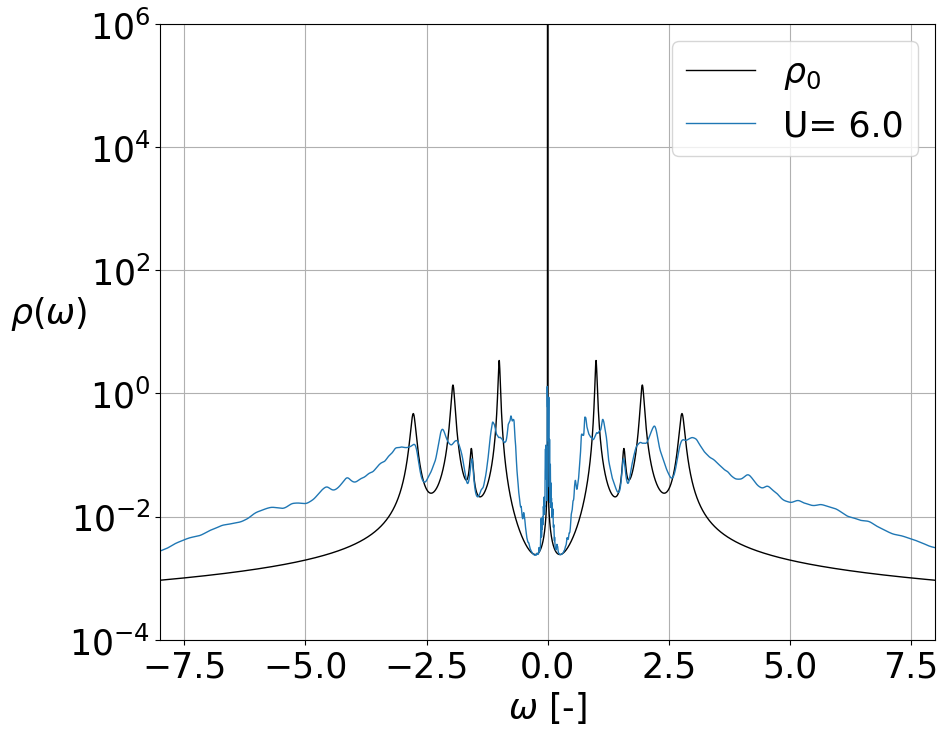

In [18]:
#all new aimsolver and constraint function
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv8.png')

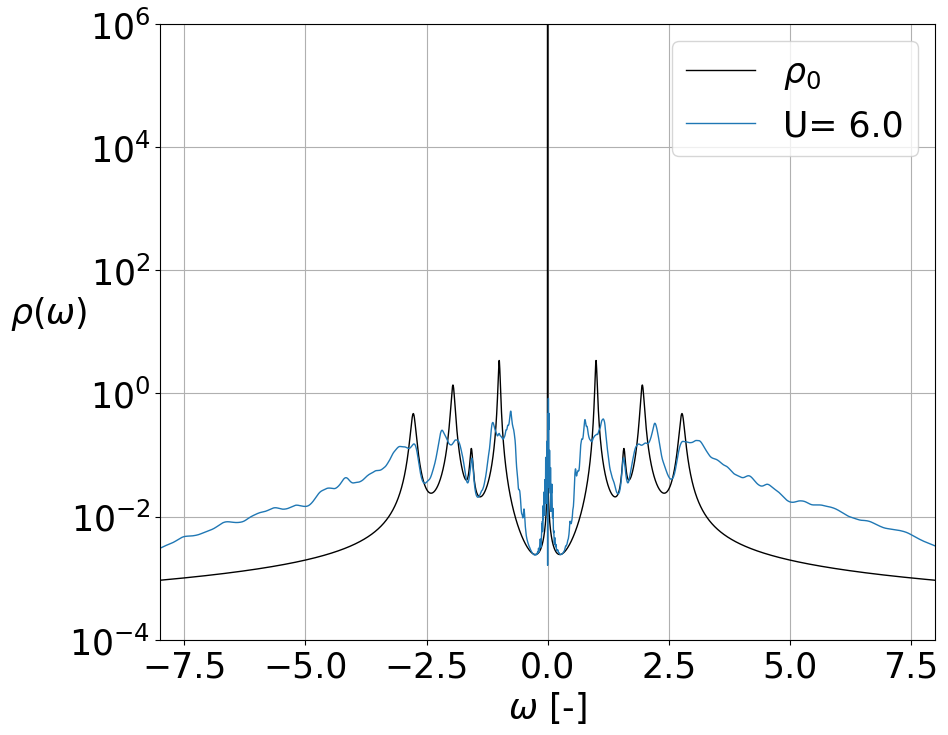

In [10]:
#Mgnew and hamiltonian new and bounadry new, when removing [2000] doesnt work
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv7.png')

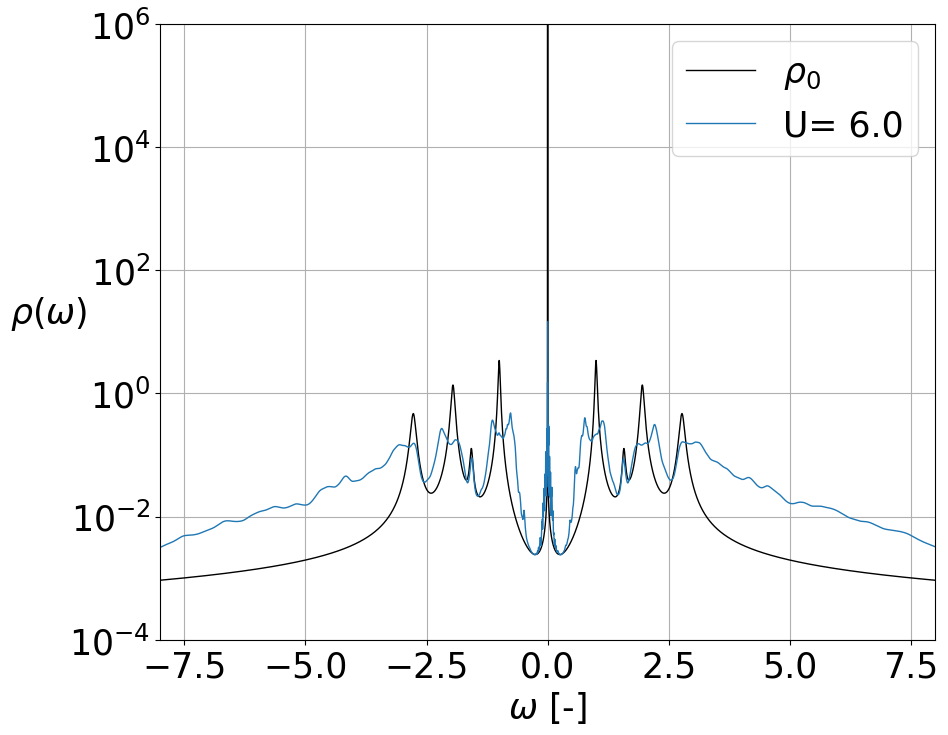

In [8]:
#Mgnew and hamiltonian new and bounadry new
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv7.png')

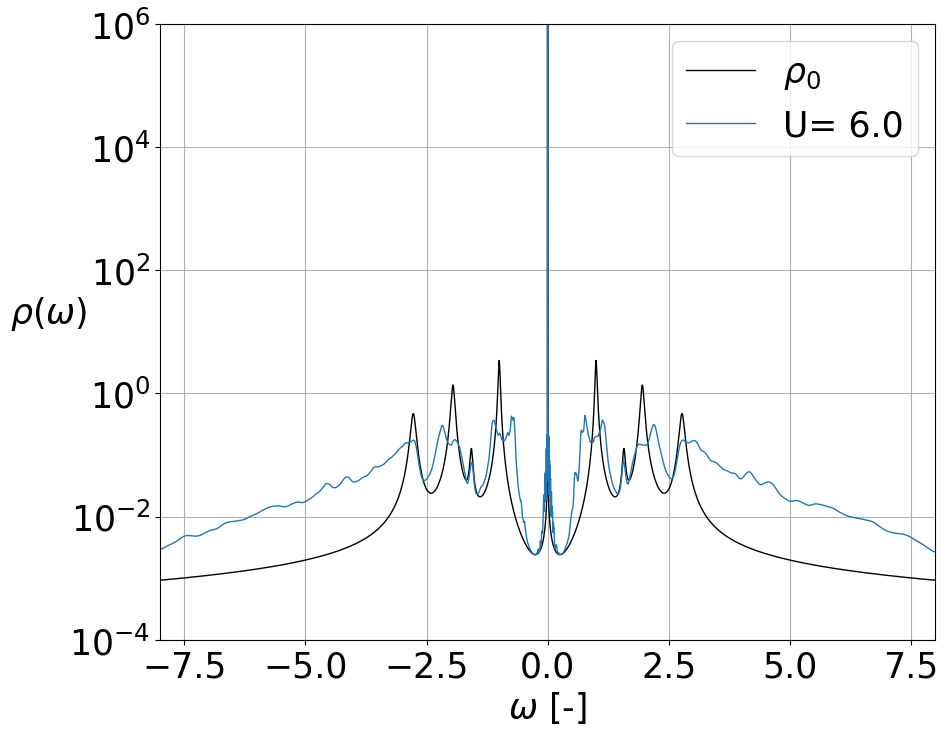

In [8]:
#with new jordanwig and str trans
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv6.png')

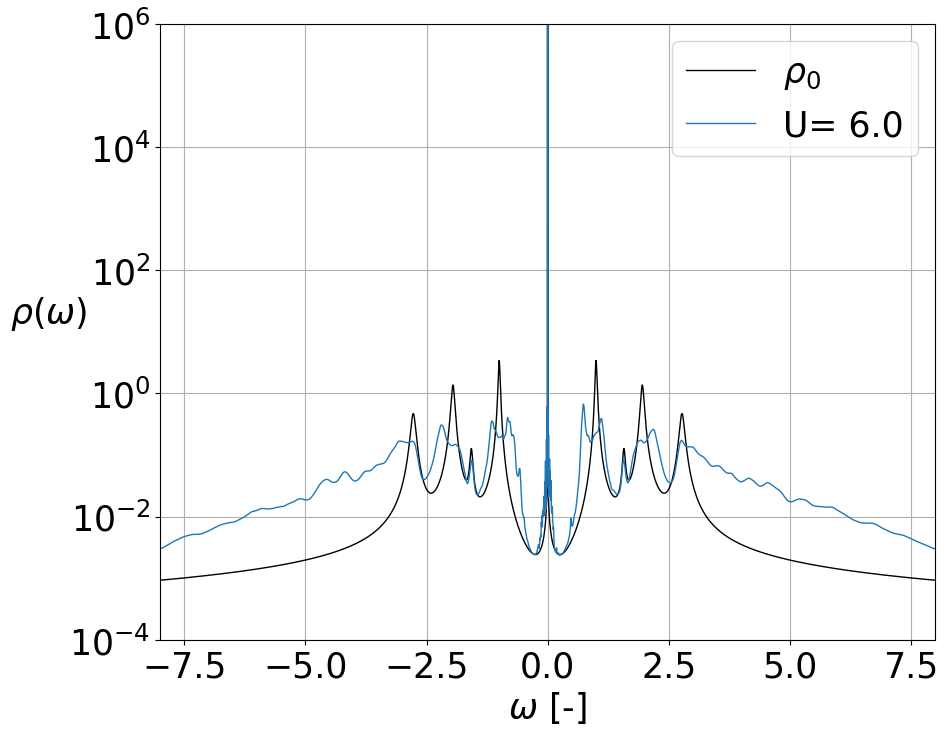

In [11]:
#with new selection poles
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv5.png')

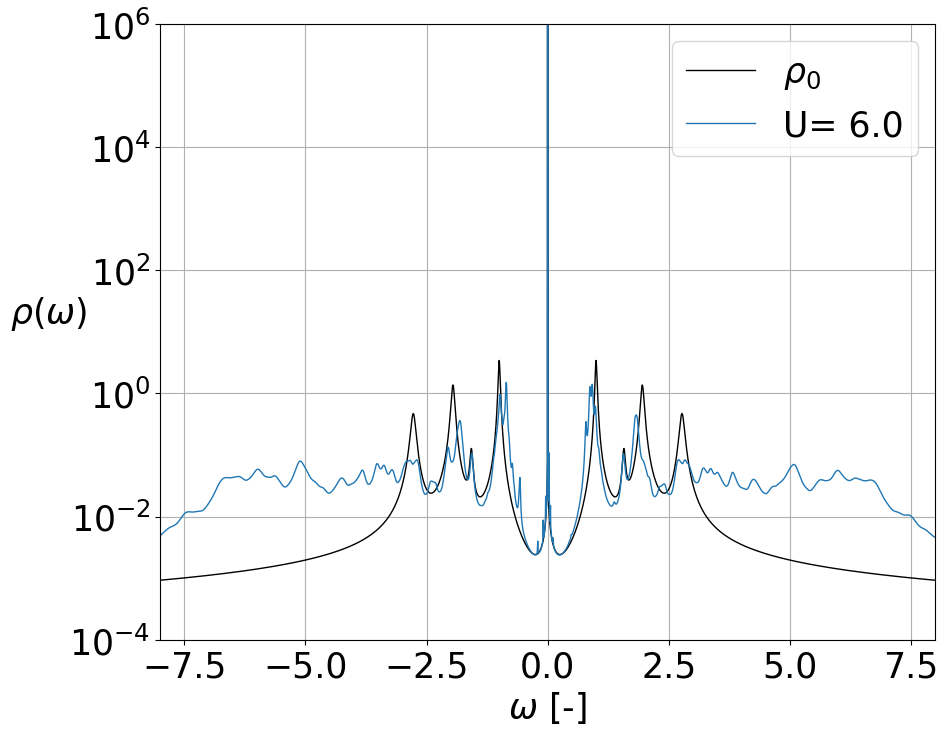

In [14]:
#with new struct
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3,label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat,label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv4.png')

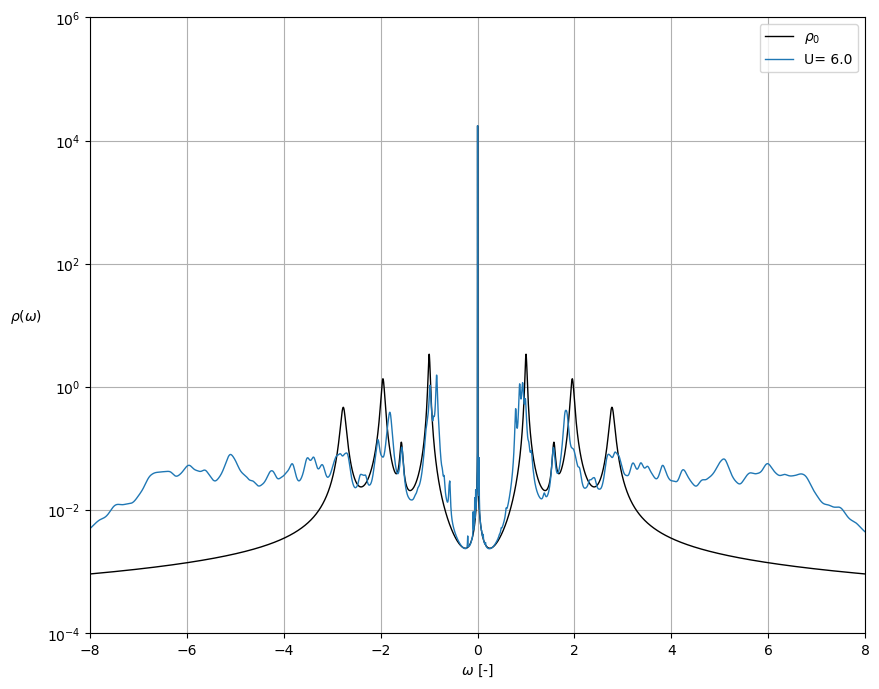

In [6]:
#original
omega= np.linspace(-8,8,4001)
plt.figure(figsize=(10,8))
plt.xlim(min(omega), max(omega))
plt.yscale('log')
plt.gca().set_ylim(bottom=0.0001,top=1000000)
plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=15)
plt.grid()
plt.xlabel("$\\omega$ [-]")
plt.plot(omega,DOS3[posimp],label='$\\rho_0$',linewidth=1,color='black')
for i in range(len(Ut)):
    plt.plot(omega,FinSigmadat[i],label='U= %.1f'%Ut[i],linewidth=1)
#plt.plot(omega,FinSigmadat[3],label='U= %.1f'%Ut[3],linewidth=1)
plt.legend()
plt.savefig('DOS_AIMGraphener=23Uncv3.png')

In [6]:
FinSigmadat=np.real(FinSigmadat)
FinSigmadat2=[omega,DOS3[posimp],FinSigmadat[0],FinSigmadat[1],FinSigmadat[2],FinSigmadat[3]]

np.savetxt('DOS_AIMGraphener=23Uncv3',np.transpose(FinSigmadat2), fmt='%.18g', delimiter='\t', newline='\n')
text_file = open("DOS_AIMGraphener=23Uncv3", "r")
lines = text_file.read().split('\n')
for i in range(len(lines)-1):
    lines[i]=lines[i].split('\t')
    for j in range(2):
        lines[i][j]=float(lines[i][j])
print(lines[0])
text_file.close()

[-8.0, 0.0009240302305529327, '0.00105888931531213418', '0.001553137697755978', '0.00294075882585171375', '0.00475075660193362715']
